# Class Activation Mapping(CAM) In PyTorch


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import numpy as np
import skimage.transform


C:\Users\mchelali\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Chargement d'une image

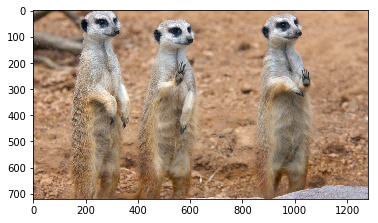

In [32]:
image = Image.open("data/aa.jpg")
imshow(image)

In [33]:
transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
print(transform)

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Transformation de l'image en tensor

In [34]:
tensor = transform(image)
print(tensor.shape)

prediction_var = Variable((tensor.unsqueeze(0)), requires_grad=True)
print(prediction_var.shape)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


### Chargement d'unmodèle entrainer

In [35]:
net = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Using cache found in C:\Users\mchelali/.cache\torch\hub\pytorch_vision_v0.5.0


Preparation des données pour voir la CAM

In [36]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

#print(net._modules.get('classifier'))       
final_layer = net._modules.get('features')[-1]
print(final_layer)

activated_features = SaveFeatures(final_layer)
print("activated_features before ", activated_features.features)
######################################################
#        Recuperation des prediction du modele       #
######################################################

prediction = net(prediction_var)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()
print("activated_features after ", activated_features.features.shape)
#print(pred_probabilities)

Fire(
  (squeeze): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
  (squeeze_activation): ReLU(inplace=True)
  (expand1x1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (expand1x1_activation): ReLU(inplace=True)
  (expand3x3): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (expand3x3_activation): ReLU(inplace=True)
)
activated_features before  None


C:\Users\mchelali\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


activated_features after  (1, 512, 13, 13)


In [37]:
confident, classe = topk(pred_probabilities,1)
print("le modele est confiant a %f pour la classe %f" % (confident, classe))

le modele est confiant a 0.934251 pour la classe 299.000000


Maintenant nous passant a la clréation de la carte d'activation

In [38]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

(1000, 512)


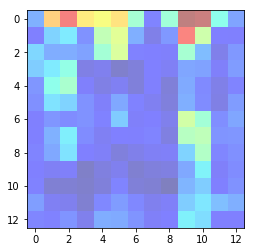

In [39]:
weight_softmax_params = list(net._modules.get('classifier').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

print(weight_softmax .shape)

class_idx = topk(pred_probabilities,1)[1].int()
overlay = getCAM(activated_features.features, weight_softmax, class_idx )
imshow(overlay[0], alpha=0.5, cmap='jet')

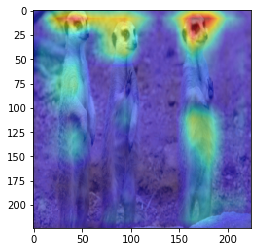

In [40]:
display_transform = transforms.Compose([
   transforms.Resize((224,224))])

imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');